In [1]:
pip install -q osmnx matplotlib networkx

Note: you may need to restart the kernel to use updated packages.


In [2]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

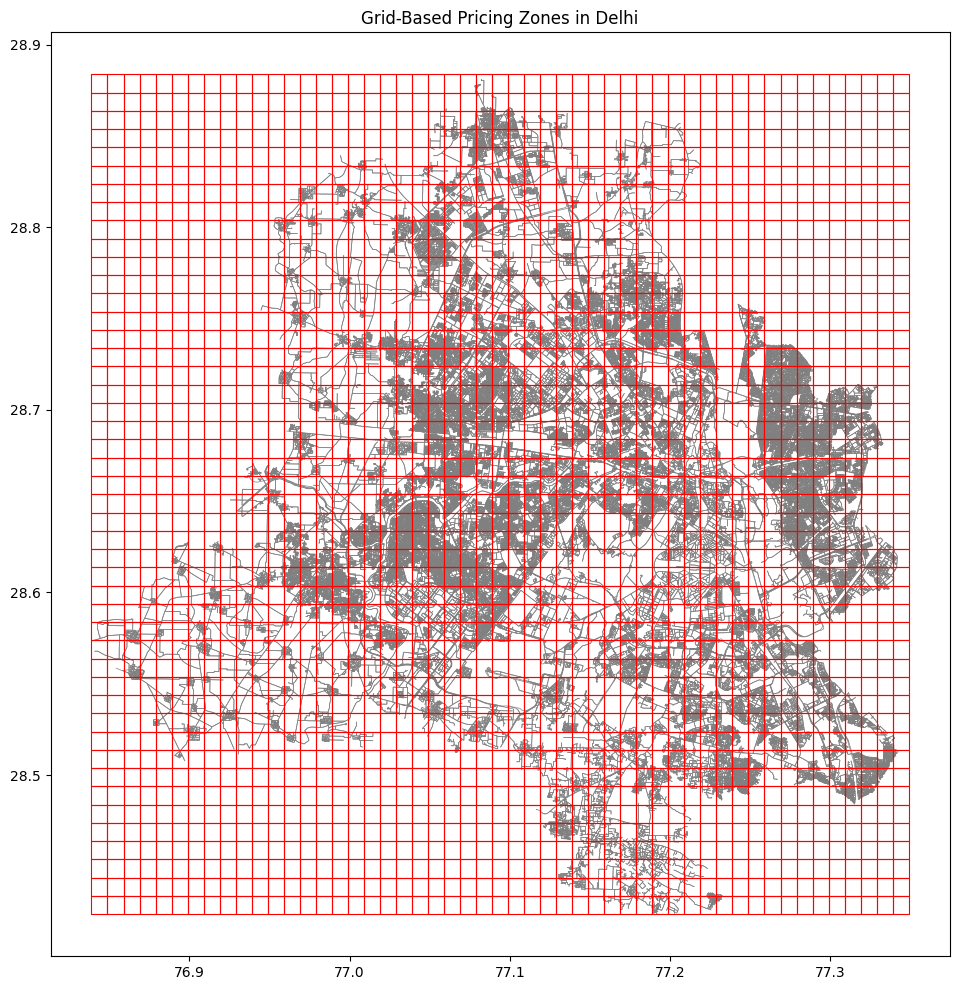

In [3]:
# Load Delhi road network
G = ox.load_graphml("../data/raw/delhi_graph.graphml")

# Convert graph nodes to GeoDataFrame
nodes, edges = ox.graph_to_gdfs(G)

# Get bounding box of Delhi
minx, miny, maxx, maxy = edges.total_bounds

# Define grid size (approx. ~1km x 1km)
grid_size = 0.01  # degrees

# Create grid polygons
x_bins = np.arange(minx, maxx, grid_size)
y_bins = np.arange(miny, maxy, grid_size)

polygons = []
zone_ids = []

for i, x in enumerate(x_bins):
    for j, y in enumerate(y_bins):
        zone_ids.append(f"Z_{i}_{j}")
        polygons.append(ox.utils_geo.bbox_to_poly(north = y+grid_size, south = y,
                                                  east = x+grid_size, west = x))

zones_gdf = gpd.GeoDataFrame({'zone_id': zone_ids, 'geometry': polygons}, crs = 'EPSG:4326')

# Plot zones over the road network
fig, ax = plt.subplots(figsize = (12, 12))
edges.plot(ax = ax, linewidth = 0.5, color = 'gray')
zones_gdf.boundary.plot(ax = ax, linewidth = 0.8, color = 'red')
plt.title("Grid-Based Pricing Zones in Delhi")
plt.show()

In [17]:
zoned_nodes = gpd.sjoin(nodes, zones_gdf, how = "inner", predicate = "intersects")

zoned_nodes_count = zoned_nodes.reset_index()\
                               .groupby(by = 'zone_id')['osmid']\
                               .count().to_frame('n_nodes').reset_index()

zoned_edges = gpd.sjoin(edges, zones_gdf, how = "inner", predicate = "intersects")

zoned_edges_count = zoned_edges.reset_index()\
                               .groupby(by = 'zone_id')['osmid']\
                               .count().to_frame('n_edges').reset_index()